In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json

from utils import Library

In [3]:
data_file = 'gutenberg/books.bin'
auxdata_file = 'gutenberg/books_metadata.json'

data = np.memmap(data_file, dtype=np.uint16, mode='r')
auxdata = []
with open(auxdata_file, 'r') as file:
    for line in file:
        auxdata.append(json.loads(line))

In [4]:
library = Library(data, auxdata)

In [7]:
num_blocks_per_book = []
for book in library:
    train_data = book['train_data']
    num_blocks_per_book.append(len(train_data))

In [18]:
batch_size = 8
num_batches_per_book = num_blocks_per_book // batch_size + 1

In [9]:
with open('results.json', 'r') as json_file:
    results = json.load(json_file)

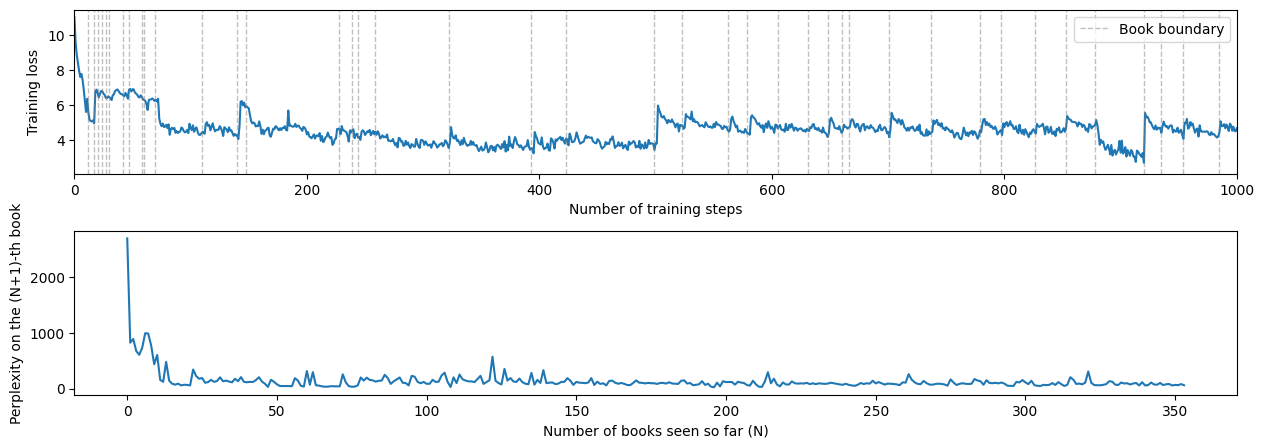

In [32]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(2, 1, figsize=(15, 5))
ax = axes[0]
ax.plot(results['tr_loss'])

for x in np.cumsum(num_batches_per_book):
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=1, alpha=0.5)

ax.set_xlim([0, 1000])

ax.set_xlabel("Number of training steps")
ax.set_ylabel("Training loss")

custom_legend = [Line2D([0], [0], color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Book boundary')]
ax.legend(handles=custom_legend, loc='upper right')

ax = axes[1]
ax.plot(results['perplexity'])

ax.set_xlabel("Number of books seen so far (N)")
ax.set_ylabel("Perplexity on the (N+1)-th book")

plt.subplots_adjust(hspace=0.35)

plt.show()